In [1]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

2.6.0





# Load data set




In [4]:
import pandas as pd
df = pd.read_excel("/content/drive/MyDrive/AutomatedQuestionGeneration/train.xlsx").drop("Unnamed: 0",axis = 1)
df.head()

,index,question,context,text,answer_start,c_id
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269.0,0
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207.0,0
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526.0,0
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",166.0,0
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,276.0,0


In [6]:
df = df[:1000]

In [7]:
context = df["context"].apply(lambda x: x).tolist()
target_ques = df["question"].apply(lambda x: x).tolist()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",","¿")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  # remove extra space
  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [70]:
en_sentence = u"Beyonce's last record was called Lemonade"
sp_sentence = u"Beyonce was born in 1950"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))
print(preprocess_sentence(sp_sentence).encode("UTF-8"))

<start> beyonce s last record was called lemonade <end>
<start> beyonce was born in <end>
b'<start> beyonce was born in <end>'


In [ ]:
# Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])
print(len(en), len(sp))

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
118964 118964


In [24]:
def create_dataset_squad(context_param,target_ques):
  context = []
  question = []
  for c,q in zip(context_param,target_ques):
    context.append(preprocess_sentence(c))
    question.append(preprocess_sentence(q))
  return context, question

c, q = create_dataset_squad(context,target_ques)
print(c[-1])
print(q[-1])
print(len(c), len(q))

<start> two polish friends in paris were also to play important roles in chopin s life there . his fellow student at the warsaw conservatory , julian fontana , had originally tried unsuccessfully to establish himself in england albert grzyma a , who in paris became a wealthy financier and society figure , often acted as chopin s adviser and gradually began to fill the role of elder brother in his life . fontana was to become , in the words of micha owski and samson , chopin s general factotum and copyist . <end>
<start> who is stated as a jack of all trades in service to frederic ? <end>
1000 1000


In [20]:
# Tokenize the sentence into list of words(integers) and pad the sequence to the same length
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

In [25]:
def load_dataset(input, target):
  # creating cleaned input, output pairs
  #targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(input)
  target_tensor, targ_lang_tokenizer = tokenize(target)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [26]:
# Try experimenting with the size of that dataset
#num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(c,q)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ, max_length_inp)

30 358


In [29]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))
print(input_tensor_train[1])
print()
print(target_tensor_train[1])

800 800 200 200
[  20   13  142    1    1   36   14  184   25    8   39    7  260  953
    1   15  585   77   26  156    1    4    2   26  451  462  452    3
    2  462 2473    4 2474 2475    5  293 1017   26 1018    3    8   10
  630   63   64  949    2 2476  264    6  452    1 2477    1    4    2
   27 2478    6    3   88    8    5   63   64    1 1060   50 2479  396
   19  924  518    1 1021    1  435    1 1013  629    1 1022 1023    5
  191  260  216  452    1   15    2 2480 2481    7 2482 2483    3    2
 2484    6  296   34   65   50 2485  451  462   14  678   23  609 1096
    9 2486    9    2 2487  548   12  451 2488    2 2489   26  267    1
    5    9 2490   77  451 2491  396   19 2492    1   31  106  217 2493
   12   32 2494 2495    6 2496    3    2 2497   39    9  362 2498    9
 2499   26  631    1    9 2500   57 2501    1  374   63   64   13    2
  161    6  452    3   21    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 

In [30]:
# Configuration 
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
steps_per_epoch_val = len(input_tensor_val)//BATCH_SIZE
embedding_dim = 256  # for word embedding
units = 1024  # dimensionality of the output space of RNN
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 358]), TensorShape([64, 30]))

# Seq2seq model: Encoder, Decoder with Additive Attention

In [31]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,  # Whether to return the last output in the output sequence, or the full sequence. 
                                   return_state=True,  # Whether to return the last state in addition to the output.
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [32]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 358, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)


  def call(self, x, hidden):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state = hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)
    return x, state

In [ ]:
# decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# sample_decoder_output, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
#                                       sample_hidden)

# print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [33]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(query_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [34]:
class DecoderWithAttention(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_layer = None):
    super(DecoderWithAttention, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = attention_layer

  def call(self, x, hidden, enc_output):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    attention_weights = None
    
    if self.attention:
      # enc_output shape == (batch_size, max_length, hidden_size)
      context_vector, attention_weights = self.attention(hidden, enc_output)
      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state = hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) 
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [36]:
print(loss_object([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))
print(loss_function([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))

tf.Tensor([1.063386  1.3633859], shape=(2,), dtype=float32)
tf.Tensor(1.2133859, shape=(), dtype=float32)


In [ ]:
# Training

In [37]:
optimizer = tf.keras.optimizers.Adam()

def get_train_step_func():

  @tf.function
  def train_step(inp, targ, enc_hidden, encoder, decoder):
    loss = 0

    with tf.GradientTape() as tape: # for automatic differentiation
      enc_output, enc_hidden = encoder(inp, enc_hidden)

      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss
    
  return train_step
    

In [38]:
def caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder):
  loss = 0
  enc_output, enc_hidden = encoder(inp, enc_hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss += loss_function(targ[:, t], predictions)
    dec_input = tf.expand_dims(targ[:, t], 1)

  loss = loss / int(targ.shape[1])
  return loss

In [39]:
def training_seq2seq(epochs, attention):
  encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
  decoder = DecoderWithAttention(vocab_tar_size, embedding_dim, units, BATCH_SIZE, attention)
  train_step_func = get_train_step_func()
  training_loss = []
  validation_loss = []

  for epoch in range(epochs):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step_func(inp, targ, enc_hidden, encoder, decoder)
      total_loss += batch_loss

      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss))
        
    enc_hidden = encoder.initialize_hidden_state()
    total_val_loss = 0
    for (batch, (inp, targ)) in enumerate(validation_dataset.take(steps_per_epoch)):
      val_loss = caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder)
      total_val_loss += val_loss

    training_loss.append(total_loss / steps_per_epoch)
    validation_loss.append(total_val_loss / steps_per_epoch_val)
    print('Epoch {} Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1,
                                        training_loss[-1], validation_loss[-1]))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  return encoder, decoder, training_loss, validation_loss

## Training seq2seq with Bahdanau attention

In [40]:
epochs = 10

attention = BahdanauAttention(units)
print("Running seq2seq model with Bahdanau attention")
encoder_bah, decoder_bah, training_loss, validation_loss = training_seq2seq(epochs, attention)

Running seq2seq model with Bahdanau attention
Epoch 1 Batch 0 Loss 2.8979
Epoch 1 Loss 2.6026 Validation Loss 2.3051
Time taken for 1 epoch 85.2699625492096 sec

Epoch 2 Batch 0 Loss 2.2474
Epoch 2 Loss 2.1109 Validation Loss 2.1039
Time taken for 1 epoch 42.50201988220215 sec

Epoch 3 Batch 0 Loss 2.1374
Epoch 3 Loss 1.9659 Validation Loss 2.0046
Time taken for 1 epoch 42.50455117225647 sec

Epoch 4 Batch 0 Loss 1.9448
Epoch 4 Loss 1.8813 Validation Loss 1.9585
Time taken for 1 epoch 42.47143340110779 sec

Epoch 5 Batch 0 Loss 1.7290
Epoch 5 Loss 1.7933 Validation Loss 1.8650
Time taken for 1 epoch 43.07177925109863 sec

Epoch 6 Batch 0 Loss 1.7711
Epoch 6 Loss 1.7042 Validation Loss 1.8502
Time taken for 1 epoch 42.372519969940186 sec

Epoch 7 Batch 0 Loss 1.6046
Epoch 7 Loss 1.6103 Validation Loss 1.7795
Time taken for 1 epoch 42.26524758338928 sec

Epoch 8 Batch 0 Loss 1.4092
Epoch 8 Loss 1.5142 Validation Loss 1.7595
Time taken for 1 epoch 42.23895788192749 sec

Epoch 9 Batch 0 Lo

NameError: ignored

In [42]:
tloss = np.vstack((tloss, training_loss))
vloss = np.vstack((vloss, validation_loss))

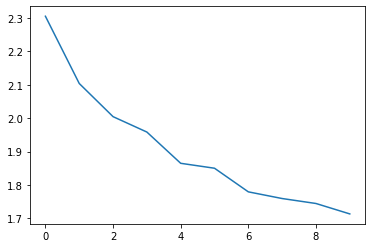

In [60]:
import matplotlib.pyplot as plt
plt.plot(np.arange(10), np.array(validation_loss))

# Translation

In [63]:
def translate(sentence, encoder, decoder):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    # until the predicted word is <end>.
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model, no teacher forcing.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [66]:
df.iloc[500,2]

'Beyoncé has received praise for her stage presence and voice during live performances. Jarett Wieselman of the New York Post placed her at number one on her list of the Five Best Singer/Dancers. According to Barbara Ellen of The Guardian Beyoncé is the most in-charge female artist she\'s seen onstage, while Alice Jones of The Independent wrote she "takes her role as entertainer so seriously she\'s almost too good." The ex-President of Def Jam L.A. Reid has described Beyoncé as the greatest entertainer alive. Jim Farber of the Daily News and Stephanie Classen of Star Phoenix both praised her strong voice and her stage presence.'

In [69]:
result, sentence = translate(u'Beyonce was born in 1950', encoder_bah, decoder_bah)
print('Input: %s' % (sentence))
print('Predicted translation: {}'.format(result))

Input: <start> beyonce was born in <end>
Predicted translation: what was the name of the name of the name of the name of the name of the film ? <end> 


In [ ]:
# Graph

In [89]:
def evaluate(sentence, target_sentence_tokenizer,max_target_length, max_source_length, source_sentence_tokenizer):
    attention_plot= np.zeros((max_target_length, max_source_length))
    #preprocess the sentnece
    sentence = preprocess_sentence(sentence)

    #convert the sentence to index based on word2index dictionary
    inputs= [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]

    # pad the sequence 
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_source_length, padding='post')

    #conver to tensors
    inputs = tf.convert_to_tensor(inputs)

    result= ''

    # creating encoder
    hidden = [tf.zeros((1, units))]
    encoder_output, encoder_hidden= encoder(inputs, hidden)

    # creating decoder
    decoder_hidden = encoder_hidden
    decoder_input = tf.expand_dims([target_sentence_tokenizer.word_index['start']], 0)
    for t in range(max_target_length):
        predictions, decoder_hidden, attention_weights= decoder(decoder_input, decoder_hidden, encoder_output)

        # storing attention weight for plotting it
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()

        prediction_id= tf.argmax(predictions[0]).numpy()
        result += target_sentence_tokenizer.index_word[prediction_id] + ' '

        if target_sentence_tokenizer.index_word[prediction_id] == '_end':
            return result,sentence, attention_plot

        # predicted id is fed back to as input to the decoder
        decoder_input = tf.expand_dims([prediction_id], 0)

    return result,sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax= fig.add_subplot(1,1,1)
    ax.matshow(attention, cmap='Greens')
    fontdict={'fontsize':10}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [90]:
def question(sentence, target_sentence_tokenizer,max_target_length, max_source_length, source_sentence_tokenizer ):
    result, sentence, attention_plot = evaluate(sentence,target_sentence_tokenizer,max_target_length, max_source_length, source_sentence_tokenizer)

    print('Input : %s' % (sentence))
    print('predicted sentence :{}'.format(result))

    attention_plot= attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [91]:
question("Beyonce was born in 1955", targ_lang,max_length_targ, max_length_inp, inp_lang)

NameError: ignored

In [92]:
attention.attention

AttributeError: ignored